In [1]:
from importlib import reload
import evosim
reload(evosim)
None

# Learning Goal: demonstrating "long-term" selection

The mutation rate possessed by a single organism does not affect its fitness.

That is, there is selection *on the organism's external phenotype*, but because mutation rate *only affects the offspring*, is not "visible" to single-generation selection. 

Nonetheless, this lab will demonstrate that there is “long-term selection” on mutation rate because it produces differential survival of clades.

# Setup
### Six possible genotypes

We will consider a fixed population size of N=10<sup>9</sup> individual organisms, each of which has a certain genotype.

There are two possible alleles at the "selected locus": *A* and *B*. The alleles *A* and *B* will have different fitnesses.

There are three possible alleles at the "mutator locus": *M<sub>2</sub>*, *M<sub>3</sub>*, *M<sub>4</sub>*. There is no direct selection on the mutator locus; it just sets the rate of mutation from *A*->*B* or *B*->*A* in offspring.

This makes a total of 2 * 3 = 6 possible genotypes:

|                   | A                       | B |
| :--------------   | :------:                | :----:               |
| *M<sub>2</sub>*   |   (*M<sub>2</sub>*, A)  | (*M<sub>2</sub>*, B) |
| *M<sub>3</sub>*   |   (*M<sub>3</sub>*, A)  | (*M<sub>3</sub>*, B) |
| *M<sub>4</sub>*   |   (*M<sub>4</sub>*, A)  | (*M<sub>4</sub>*, B) |

The organisms in our model are asexual - there is no mating/recombination. Offspring have a single parent. 

### Each generation of evolution
At each generation, in a typical population genetics model (like this one), we will:

1. Apply **selection** to determine the *number of offspring* that each individual organism will have.
2. Apply **mutation** to the selected allele at a certain mutation rate.

If there's no mutation, the offspring inherits the parent's value of A or B. If there is a mutation, the inherited allele switches *A->B* or *B->A* from the parent's value.

### Selection
There will be two environments in our model. At any generation the current "environmental state” is either *A* or *B*. This state will fluctuate over time on a schedule that I will explain below.

Environment *A* favors selected allele *A*, and environment *B* favors selected allele *B*.

Organisms holding the allele at the selected locus that matches the state of the environment will produce more offspring on average: they are more fit.

Specifically, given a “selection coefficient” *s*, the matching (fitter) organisms produce 1+*s* times as many offspring. This means that the fitter organisms will increase in relative number.


```python
def apply_selection(p, s):
    """
    Return expected fraction of A after selection.
    Assumes just 2 types: A and B.

    Args:
      p: current frequency of A (0 <= p <= 1)
      s: selection coefficient (so wA = 1 + s, wB = 1)

    Explanation of components:
      wA = 1 + s                 # fitness of A
      wB = 1                     # fitness of B
      numerator = wA * p         # A's contribution to the post-selection pool
      denominator = wA*p + wB*(1-p)  # total contribution from A and B
      result = numerator / denominator
    """
    p = float(p)
    # handle boundary cases cleanly
    if p <= 0.0:
        return 0.0
    if p >= 1.0:
        return 1.0

    wA = 1.0 + float(s)   # fitness of A
    wB = 1.0              # fitness of B

    numerator = wA * p
    denominator = numerator + wB * (1.0 - p)

    return numerator / denominator # expected frequency after selection
```

### Mutation
The alleles M2, M3, M4 at the mutator locus produce mutation rates in the selected locus of 10-2, 10-3, 10-4, respectively. The rate is symmetric, A->B, or B->A.

For example, at each generation, an individual with genotype (A, M2) produces offspring that are 99% (A, M2), and 1% (B, M2); that is, the A mutates to B in 1 out of 102 offspring.

Similarly, an individual with genotype (A, M4) produces offspring that are 99.99% (A, M4), and 0.01% (B, M4);  that is, the A mutates to B in 1 out of 104 offspring.

It's symmetrical in the other direction from B->A.

The mutator locus itself never mutates. That means that all descendants of an individual possessing an M2 at the mutator locus will always possess an M2 (and likewise for M3, M4). This constraint in our particular experimental setup makes the mutator locus a convenient marker of clade identity. So, we can refer to the M2 clade as being founded by all the M2 individuals at generation 0, and all of its descendant members will always possess an M2 forever.

```python
def apply_mutation(p, mu):
    """
    Return expected fraction of A after symmetric mutation at rate `mu`.
    Assumes just 2 types: A and B.

    Args:
      p: current frequency of A (0 <= p <= 1)
      mu: per-generation mutation probability for A->B and B->A (0 <= mu <= 1)

    Explanation of components:
      p_remain = p * (1 - mu)      # fraction of current A that do NOT mutate
      p_from_B = (1 - p) * mu      # fraction of current B that mutate to A
      result = p_remain + p_from_B # total fraction of A after mutation
    """
    p = float(p)
    mu = float(mu)

    # clamp mu to valid probability range
    if mu <= 0.0:
        return p
    if mu >= 1.0:
        # if mu == 1, all alleles flip, so new freq A = 1 - p
        return 1.0 - p

    p_remain = p * (1.0 - mu)
    p_from_B = (1.0 - p) * mu

    return p_remain + p_from_B # expected frequency after mutation
```

### Sampling from a binomial distribution – which produces drift

mean: 4.007		should be ~Np: 4.000
stddev/N: 0.08982	should be ~sqrt(p(1-p)/N): 0.08944


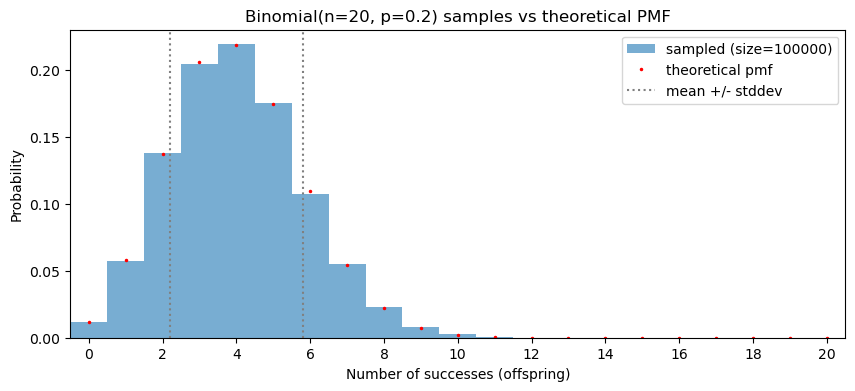

In [8]:
from helpers import plot_binomial_samples

# N - number of individuals in the population
# p - what fraction of the population will a given genotype make up, on average
#    p is determined by selection coefficient s, the mutation rate mu, and the previous proportions of genotypes.

# Then we draw a sample from a binomial distribution with parameters N and p
#    The mean of the binomial distribution is N*p - average number of individuals of that type
#    The min of the binomial is 0 - no individuals of that type
#    The max of the binomial is N - all individuals are of that type

N = 20 # 100
p = 0.2 # 0.2
plot_binomial_samples(N, p)

# Learning Goal – elaborated:

In each generation,
- Selection determines the *number of offspring* an organism has – its fitness.
- However, selection does not determine the *genotypes of the offspring*.
- Rather, *the mutation rate* determines the *distribution of genotypes* in the offspring.

So, individual organisms are selected (i.e., their fitness is determined) depending *only* on the allele they hold at the selected locus, and whether it matches the environmental state.

The mutation rate is not "visible" to selection over one generation.

However – by affecting the distribution of genotypes in the offspring – the mutation rate becomes visible to multi-generation selection!

Recall that a clade will "survive" (or not) if it retains one member (or not). That depends on the distribution of the offspring genotypes.

That is, clades can experience "long-term" selection on mutation rate!

- Moreover, this is just a special case of a more general selection on clades for not just mutation rate, but *for anything that affects the distribution of genotypes in their members*. (but we don't look at that in this demonstration)

- More-moreover, in the even longer-term, there is selection on *change* in mutation rate... and the change in *that*... and the change in *that*! That is, there is a recursive dynamic! (but not in this demonstration because we fix the mutation rates)


---
---
# Simulations

In [4]:
display("default arguments:", evosim.default_args)

'default arguments:'

{'numPops': 1,
 'N': 100000.0,
 'minMu': 2,
 'numClades': 1,
 'aToB': 0.5,
 'T': 1000.0,
 'numEpochs': 1,
 's': 0.1,
 'skipMutation': False,
 'plotLog': False,
 'plotAB': True,
 'print_stats': True}

---
---
### Drift (no selection or mutation)

Drift is change in genotype frequencies due to stochasticity (e.g., in number of offspring produces

Drift is stronger with low N (population size).

- Change N between 1e2 and 1e9

Re-run (Ctrl-return) multiple times with different parameters.

args: {'numPops': 1, 'N': 1000.0, 'minMu': 2, 'numClades': 1, 'aToB': 0.5, 'T': 4000.0, 'numEpochs': 1, 's': 0.0, 'skipMutation': True, 'plotLog': False, 'plotAB': True, 'print_stats': True}
Ns:0.0 is low < 10.0 (selection is WEAK relative to drift)
sT:0.0 is low < 20.0 (fixation WON'T usually happen in one epoch)
gen:0 epoch:0
	pop 0	sumN: 1001.00	(env A:	sA=0.0	sB=0.0)
		clade M2:	(n=  1001	 nA=   506	 nB=   495)	(mu:1.0e-02)


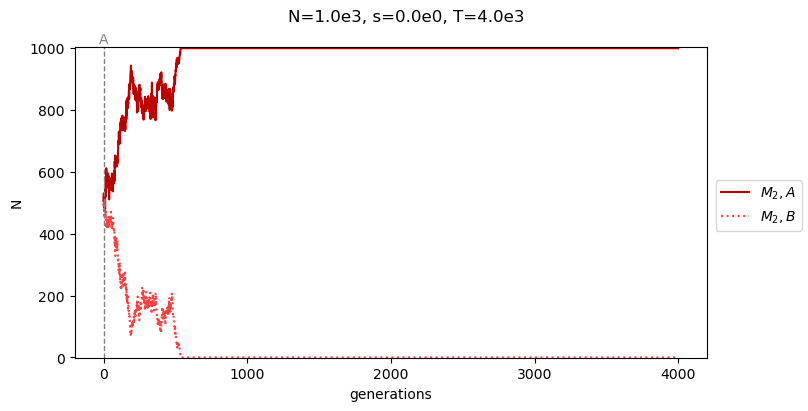

In [5]:
# Goal: to see effect of population size on drift
override_args = evosim.default_args.copy()

override_args.s = 0.0 # no selection when s=0.0
override_args.skipMutation = True # True = no mutation
override_args.N = 1e3 # 1e3
override_args.T = 4e3 # 3e3
override_args.numClades = 1 # 1
override_args.numPops = 1
override_args.skipMutation = True
#override_args.print_stats = True

evosim.evosim(override_args)
# Re-run multiple times (Ctrl-return) with different parameters.
# experiment 1: change N between 1e2 and 1e9, re-run multple times (Ctrl-return) 
# experiment 2: compare large N to N=-1 (which means infinite population)
# experiment 3: restore N=1e4 and T=2e3. Increase numClades to 2 or 3

---
---
### Selection (without mutation)

Change N to see differential effect of selection vs drift.

Change s to see effect of selection strength.

- if sT is low (<= 5.0), then fixation won't usually happen in one epoch (T generations)
- if Ns is low (<= 1.0), then drift will be strong relative to selection
- Type *A* should fix if Ns > 1, and sT > 5


Re-run multiple times (Ctrl-return) with different parameters.

args: {'numPops': 1, 'N': 100000.0, 'minMu': 2, 'numClades': 3, 'aToB': 0.5, 'T': 1000.0, 'numEpochs': 1, 's': 0.1, 'skipMutation': True, 'plotLog': False, 'plotAB': True, 'print_stats': True}
Ns:10000.0 >= 10.0 (selection is STRONG relative to drift)
sT:100.0 >= 20.0 (fixation CAN happen in one epoch (ignoring mutation))
gen:0 epoch:0
	pop 0	sumN: 99734.00	(env A:	sA=0.1	sB=0.0)
		clade M2:	(n= 33213	 nA= 16560	 nB= 16653)	(mu:1.0e-02)
		clade M3:	(n= 33291	 nA= 16630	 nB= 16661)	(mu:1.0e-03)
		clade M4:	(n= 33230	 nA= 16682	 nB= 16548)	(mu:1.0e-04)


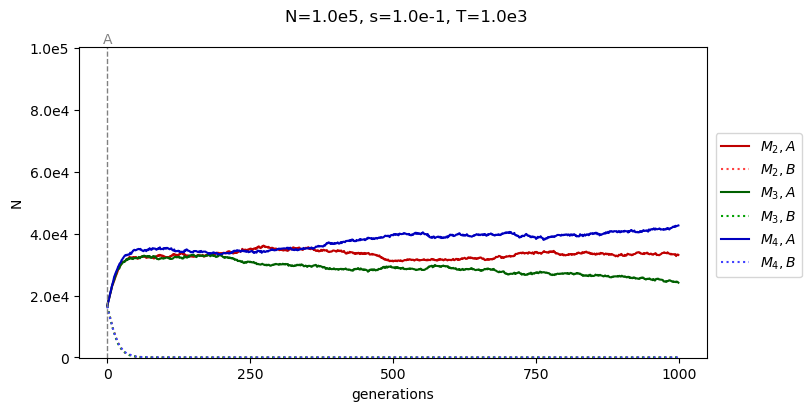

In [6]:
# Goal: to see effect of selection vs. drift
override_args = evosim.default_args.copy()

override_args.s = 0.1 # no selection when s=0.0
override_args.skipMutation = True # True = no mutation

override_args.N = 1e5
override_args.numClades = 3
override_args.T = 1e3

evosim.evosim(override_args)
# Re-run multiple times (Ctrl-return) with different parameters.
# experiment 1: change s between 0.001, 0.001, 0.1, re-run multple times (Ctrl-return) 
# experiment 2: compare large N to N=-1 (which means infinite population)

---
---
### Selection vs mutation, and mutation-selection balance

args: {'numPops': 1, 'N': -1, 'minMu': 8, 'numClades': 1, 'aToB': 0.5, 'T': 1000.0, 'numEpochs': 1, 's': 0.01, 'skipMutation': False, 'plotLog': False, 'plotAB': True, 'print_stats': True}
Infinite population size N (there is no drift)
sT:10.0 is low < 20.0 (fixation WON'T usually happen in one epoch)
gen:0 epoch:0
	pop 0	sumN: 1.00	(env A:	sA=0.01	sB=0.0)
		clade M8:	(freqA=5.00e-01	 freqB=5.00e-01)	(mu:1.0e-08)


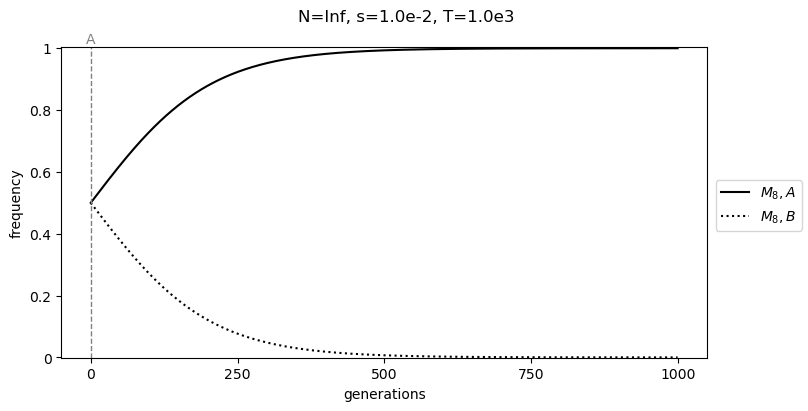

In [7]:
# Goal: to see effect of selection vs mutation, and mutation-selection balance
override_args = evosim.default_args.copy()

override_args.s = 0.01 # no selection when s=0.0
override_args.skipMutation = False # False = with mutation

override_args.minMu = 8

override_args.N = -1
override_args.numClades = 1
override_args.T = 1e3

evosim.evosim(override_args)

# Re-run multiple times (Ctrl-return) with different parameters.
# experiment 1: change minMu between 2 and 8, re-run multple times (Ctrl-return)
# experiment 2: compare large N to N=-1 (which means infinite population)

---
---
### Selection in alternating environments

args: {'numPops': 1, 'N': 1000000, 'minMu': 2, 'numClades': 5, 'aToB': 0.5, 'T': 100000.0, 'numEpochs': 4, 's': 0.1, 'skipMutation': False, 'plotLog': True, 'plotAB': False, 'print_stats': True}
Ns:100000.0 >= 10.0 (selection is STRONG relative to drift)
sT:10000.0 >= 20.0 (fixation CAN happen in one epoch (ignoring mutation))
gen:0 epoch:0
	pop 0	sumN: 1000470.00	(env A:	sA=0.1	sB=0.0)
		clade M2:	(n=200196	 nA= 99983	 nB=100213)	(mu:1.0e-02)
		clade M3:	(n=199556	 nA= 99819	 nB= 99737)	(mu:1.0e-03)
		clade M4:	(n=200340	 nA= 99985	 nB=100355)	(mu:1.0e-04)
		clade M5:	(n=200503	 nA=100026	 nB=100477)	(mu:1.0e-05)
		clade M6:	(n=199875	 nA= 99753	 nB=100122)	(mu:1.0e-06)
gen:100000 epoch:1
	pop 0	sumN: 1002459.00	(env B:	sA=0.0	sB=0.1)
		clade M2:	(n=     0	 nA=     0	 nB=     0)	(mu:1.0e-02)
		clade M3:	(n=     0	 nA=     0	 nB=     0)	(mu:1.0e-03)
		clade M4:	(n=     0	 nA=     0	 nB=     0)	(mu:1.0e-04)
		clade M5:	(n=333351	 nA=333330	 nB=    21)	(mu:1.0e-05)
		clade M6:	(n=669108	

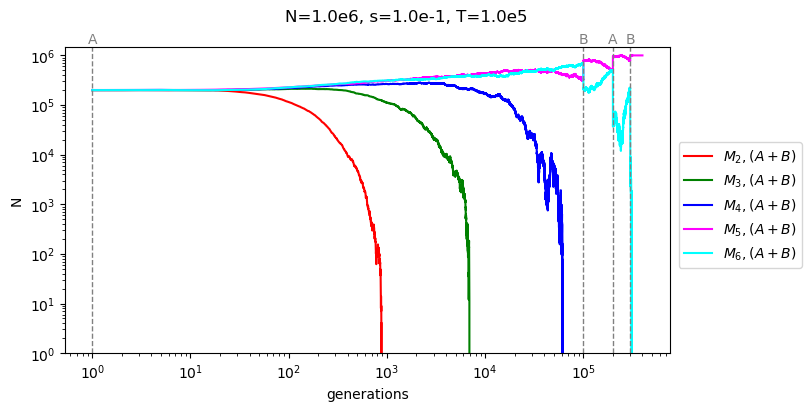

In [8]:
override_args = evosim.default_args.copy()

override_args.minMu = 2
override_args.numClades = 5

override_args.s = 0.1 # change this to see effect of selection strength
override_args.skipMutation = False

override_args.T = 1e5
override_args.numEpochs = 4

override_args.N = 1000000 # change this and re-run to see differential effect of selection vs drift
override_args.plotAB = False
override_args.plotLog = True

evosim.evosim(override_args)

---
---
### Selection on different mutators (!!) in alternating environments

args: {'numPops': 1, 'N': -1, 'minMu': 2, 'numClades': 3, 'aToB': 0.5, 'T': 1000.0, 'numEpochs': 4, 's': 0.1, 'skipMutation': False, 'plotLog': False, 'plotAB': True, 'print_stats': False}
Infinite population size N (there is no drift)
sT:100.0 >= 20.0 (fixation CAN happen in one epoch (ignoring mutation))


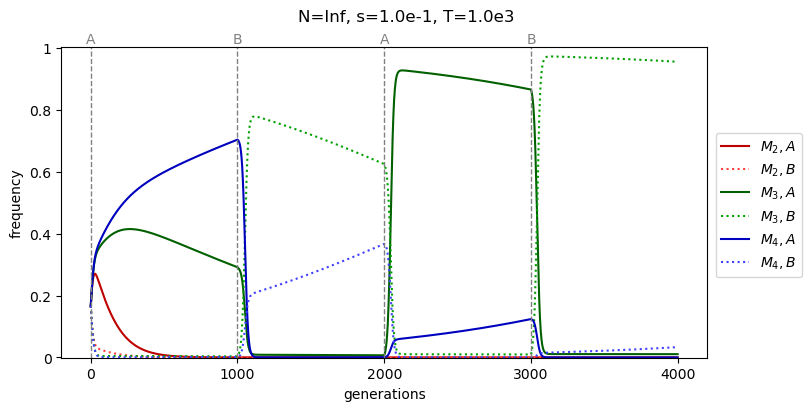

In [9]:
override_args = evosim.default_args.copy()

override_args.minMu = 2
override_args.numClades = 3

override_args.s = 0.1 # change this to see effect of selection strength
override_args.skipMutation = False

override_args.T = 1e3
override_args.numEpochs = 4
override_args.print_stats = False

override_args.N = -1 # change this and re-run to see differential effect of selection vs drift
override_args.plotAB = True

evosim.evosim(override_args)